Purpose: Train Random Forest and XGBoost models, evaluate, explain with SHAP, and save models.

RandomForest Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     56863
           1       0.96      0.98      0.97     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726

ROC-AUC: 0.9925888828165859


e:\Fourise\Fraud-Detaction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:21:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     56863
           1       0.89      0.88      0.88     56863

    accuracy                           0.89    113726
   macro avg       0.89      0.89      0.89    113726
weighted avg       0.89      0.89      0.89    113726

ROC-AUC: 0.9591989720962425


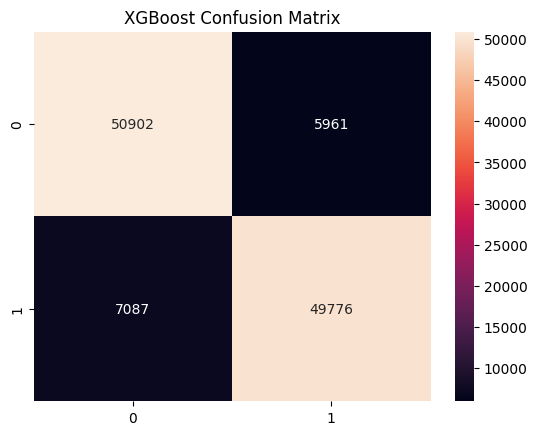

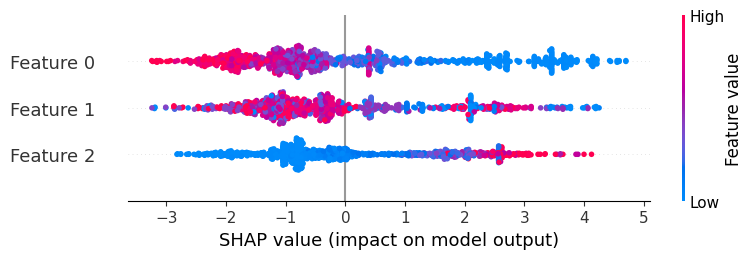

In [1]:
# %%
# 02-models.ipynb — ML model training & evaluation
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb

# Load processed data
data = np.load('../data/processed_data.npz')
X_res = data['X_res']
y_res = data['y_res']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:,1]
print("RandomForest Report:")
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))

# Save model
joblib.dump(rf, '../models/rf_model.joblib')

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
print("XGBoost Report:")
print(classification_report(y_test, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_test, xgb_probs))

# Save model
joblib.dump(xgb_model, '../models/xgb_model.joblib')

# Confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("XGBoost Confusion Matrix")
plt.show()

# Explainability
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test[:1000])
shap.summary_plot(shap_values, X_test[:1000])
